# COMP47590 Advanced Machine Learning
# Pefroming a Machine Learning Benchmarking Experiment in Python

## Imports

Import the libraries we will use - **aeon** is the new one we use for nice benchmarking imlpementations.

In [ ]:
# If using Google Colab uncomment this line to add the aeon package.
#jin giacomo 24216191
!pip install aeon

In [56]:
import io
import random
import time
import pickle

import pandas as pd # core data handling package
import numpy as np # core data handling package
import matplotlib # core plotting functioanlity
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # nicer plotting functionlity

import sklearn # For basic machine learning functionality
import sklearn.preprocessing
import sklearn.metrics
import sklearn.model_selection
import sklearn.tree
import sklearn.ensemble

import aeon # time series classification package with nice benchmarking functions
import aeon.benchmarking
import aeon.benchmarking.stats
import aeon.visualisation



## Google Colab

If using Google Colab comment out code in these cells to mount your Google drive for data access.

In [57]:
#from google.colab import drive
#drive.mount('/content/drive')

Uncomment this code and change the path to match where you have stored course data

In [58]:
#%cd /content/drive/MyDrive/Teaching/UCD Advanced Machine Learning/2024-2025/Labs Public/

## Setup

Take only a sample of the dataset for fast testing

In [59]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [60]:
grid_search_cv_folds = 2

Setup the number of folds for all grid searches (should be 5 - 10)

In [61]:
final_cv_folds = 2

Set up a dictionary to store simple model performance comparions

In [62]:
model_evaluation_results = dict()

### Setup Datasets

Set up a dictionary to store details of datasets to be used in the experiment

In [63]:
datasets = dict()

Load the dataset and explore it.

In [64]:
dataset_details = dict()
dataset_details["file_name"] = 'mnist_train.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "0", 1:"1", 2: "2", 3:"3", 4:"4", 5:"5", 6:"6", 7:"7", 8:"8", 9:"9"}
datasets["mnist"] = dataset_details

In [65]:
dataset_details = dict()
dataset_details["file_name"] = 'fashion-mnist_train.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
datasets["mnist_fashion"] = dataset_details

In [66]:
dataset_details = dict()
dataset_details["file_name"] = 'kmnist.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "0", 1:"1", 2: "2", 3:"3", 4:"4", 5:"5", 6:"6", 7:"7", 8:"8", 9:"9"}
datasets["kmnist"] = dataset_details

In [67]:
dataset_details = dict()
dataset_details["file_name"] = 'berber-mnist.csv'
dataset1 =pd.read_csv('berber-mnist.csv')
dataset_details["target_feature"] = dataset1.columns[0]
dataset_details["num_classes"] = 34
dataset_details["classes"] = {0:"A",1:"Ԑ",2:"B",3:"C",4:"Č",5:"D",6:"Ḍ",7:"E",8:"F",9:"G",10:"Ǧ",11:"H",12:"Ḥ",13:"I",14:"J",15:"K",16:"L",17:"M",18:"N",19:"Q",20:"Γ",21:"R",22:"Ṛ",23:"S",24:"Ṣ",25:"T",26:"Ṭ",
                 27:"TT",28:"U",29:"W",30:"X",31:"Y",32:"Z",33:"Ẓ"}
datasets["berber-mnist"] = dataset_details

### Setup Models

Setup a dictioanry of models and hyper-parramtee training details that will be evaluated.

In [68]:
models = dict()

Decision Tree

In [69]:
model_details = dict()
model_details['base_model'] = sklearn.tree.DecisionTreeClassifier()
model_details['param_grid'] ={'criterion': ['gini', "entropy"],
                              'max_depth': list(range(6, 13, 3)),
                              'min_samples_split': [50]}
models['decision_tree'] = model_details

K-Nearest Neighbors

In [70]:
model_details = dict()
model_details['base_model'] = sklearn.neighbors.KNeighborsClassifier()
model_details['param_grid'] = {
    'n_neighbors': list(range(3,6,2)),
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan']}
models['knn'] = model_details

Naive Bayes

In [71]:
from sklearn.naive_bayes import GaussianNB
model_details = dict()
model_details['base_model'] = sklearn.naive_bayes.GaussianNB()
model_details['param_grid'] = {
    'var_smoothing': [1e-7, 1e-6]
}
models['naive_bayes'] = model_details

Bagging

In [72]:
model_details = dict()
model_details['base_model'] = sklearn.ensemble.BaggingClassifier(estimator = sklearn.tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200))
model_details['param_grid'] ={'n_estimators': list(range(350, 451, 50))}
models['bagging'] = model_details

Gradient Boosting

In [73]:
#model_details = dict()
#model_details['base_model'] = sklearn.ensemble.GradientBoostingClassifier(max_depth = 3)
#model_details['param_grid'] = {'n_estimators': list(range(50, 501, 100)),
#                               'learning_rate': [0.001, 0.01, 0.1]}
#models['gradient_boosting'] = model_details

Random Forest

In [74]:
model_details = dict()
model_details['base_model'] = sklearn.ensemble.RandomForestClassifier(min_samples_split=200)
model_details['param_grid'] = {'n_estimators': list(range(50, 501, 100)),
                               'max_features': list(range(2, 9, 2))}
models['random_forest'] = model_details

## Experiment Loop

Iterate through each dataset and then for each model. For exach combination perfomr a hyper-parameter tuning grid search and a final cross validation experiment.

In [75]:
data_model_evaluation_results = dict()

for dataset_name in datasets:

    print(dataset_name)

    dataset_details = datasets[dataset_name]

    file_name = dataset_details["file_name"]
    target_feature = dataset_details["target_feature"]
    num_classes = dataset_details["num_classes"]
    classes = dataset_details["classes"]

    dataset = pd.read_csv(file_name)
    dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everything runs smoothly

    X = dataset.loc[:, dataset.columns != target_feature]
    y = dataset[target_feature]

    if y.isnull().any():
        print(f"\tDataset '{dataset_name}' contains NaN values in the target variable '{target_feature}'.")

    model_evaluation_results = dict()

    for model_name in models:

        print("\t{}".format(model_name))

        model_details = models[model_name]

        evaluation_results = dict()

        # Perform a grid search
        print('\t\tPerforming grid search')
        grid_search_results = sklearn.model_selection.GridSearchCV(model_details['base_model'],
                                                                   model_details['param_grid'],
                                                                   cv=grid_search_cv_folds, verbose = 1,
                                                                   n_jobs = -1)
        grid_search_results.fit(X, y)
        print("\t\tBest Parameters: {}".format(grid_search_results.best_params_))

        # Store the grid search results
        evaluation_results['best_params'] = grid_search_results.best_params_
        evaluation_results['best_score'] = grid_search_results.best_score_
        evaluation_results['cv_results'] = grid_search_results.cv_results_

        # Perform final cross validation
        print('\t\tPerforming final cross validation')
        best_model = grid_search_results.best_estimator_
        cv_results = sklearn.model_selection.cross_validate(best_model, X, y, cv=final_cv_folds)
        print("\t\t{} +/- {}".format(cv_results['test_score'].mean(), cv_results['test_score'].std()))

        # Store the cross validation results
        evaluation_results['final_cv_results'] = cv_results
        evaluation_results['final_cv_mean'] = cv_results['test_score'].mean()
        evaluation_results['final_cv_std_dev'] = cv_results['test_score'].std()

        # Add all evaluation details to the evaluation dictionary
        model_evaluation_results[model_name] = evaluation_results

        with open('evaluation_results_' + time.strftime("%Y%m%d_%H%M%S") + '.data', 'wb') as f:
            pickle.dump(model_evaluation_results, f)

    data_model_evaluation_results[dataset_name] = model_evaluation_results

mnist
	decision_tree
		Performing grid search
Fitting 2 folds for each of 6 candidates, totalling 12 fits
		Best Parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 50}
		Performing final cross validation
		0.7175 +/- 0.0025000000000000022
	knn
		Performing grid search
Fitting 2 folds for each of 4 candidates, totalling 8 fits
		Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
		Performing final cross validation
		0.9198333333333333 +/- 0.0011666666666667047
	naive_bayes
		Performing grid search
Fitting 2 folds for each of 2 candidates, totalling 4 fits
		Best Parameters: {'var_smoothing': 1e-06}
		Performing final cross validation
		0.6288333333333334 +/- 0.003166666666666651
	bagging
		Performing grid search
Fitting 2 folds for each of 3 candidates, totalling 6 fits
		Best Parameters: {'n_estimators': 350}
		Performing final cross validation
		0.6218333333333332 +/- 0.03583333333333333
	random_forest
		Performing grid search
Fittin

## Comparing Models

Generate table of model perfomrances form the dictiaonry containing experiment results.

In [76]:
data = []
for row_key, sub_dict in data_model_evaluation_results.items():
    row_data = {"Index": row_key}
    for col_key, inner_dict in sub_dict.items():
        row_data[col_key] = inner_dict.get('final_cv_mean', None)  # Extract the specific value
    data.append(row_data)
results_df = pd.DataFrame(data).set_index("Index")
print(results_df)

               decision_tree       knn  naive_bayes   bagging  random_forest
Index                                                                       
mnist               0.717500  0.919833     0.628833  0.621833       0.822000
mnist_fashion       0.743167  0.813000     0.607500  0.626833       0.792833
kmnist              0.584333  0.899167     0.529333  0.416333       0.734667
berber-mnist        0.698201  0.911444     0.648318  0.542745       0.719534


Convert to ranks.

In [77]:
ranks_df = results_df.rank(method="min", ascending=False, axis = 1)
print(ranks_df)

               decision_tree  knn  naive_bayes  bagging  random_forest
Index                                                                 
mnist                    3.0  1.0          4.0      5.0            2.0
mnist_fashion            3.0  1.0          5.0      4.0            2.0
kmnist                   3.0  1.0          4.0      5.0            2.0
berber-mnist             3.0  1.0          4.0      5.0            2.0


Perfrom a Friedman test to see if there is a difference in model performances.

In [78]:
aeon.benchmarking.stats.check_friedman(ranks_df.values)

0.003939596491115125

Perform a Nemenyi test to to see where the differences are.

In [79]:
avg_ranks = np.mean(ranks_df, axis=0)
print(avg_ranks)
aeon.benchmarking.stats.nemenyi_test(avg_ranks, len(avg_ranks), 0.05)

decision_tree    3.00
knn              1.00
naive_bayes      4.25
bagging          4.75
random_forest    2.00
dtype: float64


array([[ True, False,  True,  True, False],
       [ True,  True, False, False,  True],
       [False, False,  True,  True, False],
       [False, False, False,  True, False],
       [ True, False,  True,  True,  True]])

Draw a critical differences plot to see where differences between model perfomrance exists.

In [80]:
ranks_df.index

Index(['mnist', 'mnist_fashion', 'kmnist', 'berber-mnist'], dtype='object', name='Index')

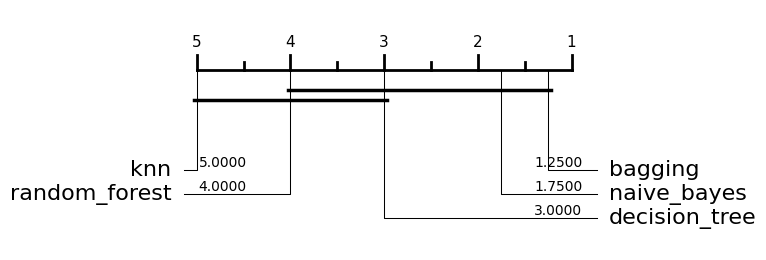

In [81]:
aeon.visualisation.plot_critical_difference(ranks_df.values,
                                            ranks_df.columns,
                                            test="Nemenyi")
plt.show()